# IN PROGRESS

**Description**: first attempt at a computational comparison using the COPA data and (binary) classification task.

**Estimated run time**: ~1 min.

**Environment**: dev

**Other**: run [this notebook in Google Colab](https://drive.google.com/file/d/1kYQ5NRmmf_LH14EF1RNYEAWGw9NfuPZG/view?usp=sharing) on a GPU.

**TODO**: figure out what exactly I want to do here.

[Motivation](#motivation)

[Setup](#setup)

[Load data and model](#load-data-and-model)

[Write prompt](#write-prompt)

[Repeat completions](#repeat-completions)

[Utilities](#utilities)

[Run CALLM](#run-callm)

[Run CVS](#run-cvs)

[Plot](#plot)

# Motivation

What's the computational performance of CALLM?

For a refresher on this method, see the [Example section here](https://stats.stackexchange.com/q/601159/337906).

Prompt-completion classification requires as many `model()` calls as there are classes. But we can exploit the auto-regressive nature of GPT to remove repeated computation for the prompts. I'll add more on how this is done at a high-level. The low-level implementation is in [`callm.huggingface.classify`](https://github.com/kddubey/callm/blob/main/callm/huggingface/classify.py).

Greedy sampling can't be parallelized.

There are three factors which determine runtime:
  1. The number of classes in the classification problem
  2. The number of tokens in the prompt
  3. The number of tokens in each completion/class.

We *could* exhaustively collect runtimes for many combinations of (1), (2), and (3). But that's expensive and doesn't directly answer the question we care about: across all *real-world* text classification tasks and datasets, what's the computational performance of this method vs CVS? I think it's safe to assume that the real-world distributions of (1), (2), and (3) are somewhat concentrated, so we don't need to uniformly compute things. To efficiently and directly (but approximately) answer the question we care about, we should sample a bunch of real-world text datasets and collect runtimes.

# Setup

Since GPT-x models are pretty much exclusively run on GPUs, this notebook should be run on a GPU machine. So run [this notebook in Google Colab](https://drive.google.com/file/d/1ehO5YfLDGawtajEe2E3QnWPQjXe7cOZs/view?usp=sharing) on a GPU. To get a (spot) GPU machine in Colab: Runtime -> Change runtime type -> Hardware accelerator: GPU.

If you're in Google Colab, you should uncomment and run this cell:

In [1]:
!python -m pip install "callm[demos] @ git+https://github.com/kddubey/callm.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kddubey/callm.git to /tmp/pip-install-oai7tdis/callm_094db0b866cf454d8b6dee60af2bbef5
  Running command git clone --filter=blob:none --quiet https://github.com/kddubey/callm.git /tmp/pip-install-oai7tdis/callm_094db0b866cf454d8b6dee60af2bbef5
  Resolved https://github.com/kddubey/callm.git to commit 0fccef5c0b06e91a616c18ebb0af0a68d1259b23
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.4 MB/s eta 0:00:00
     ━━━━━

In [2]:
from __future__ import annotations
from time import time
from typing import Literal

import datasets as nlp_datasets
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

from callm.example import Example
from callm.huggingface import classify as fast
from callm.huggingface import classify_slow as slow

In [3]:
assert torch.cuda.is_available(), 'This experiment should be run on a GPU'

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load data and model

In [5]:
def load_super_glue(task_id: str, split: str):
    return pd.DataFrame(nlp_datasets
                        .load_dataset('super_glue', task_id, split=split))


## takes about 12 seconds, sorry
df = (pd.concat((load_super_glue('copa', 'train'),
                 load_super_glue('copa', 'validation')))
      .reset_index(drop=True)) ## the idx column is only unique w/in splits! fuhgetaboutit

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset super_glue downloaded and prepared to /root/.cache/huggingface/datasets/super_glue/copa/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed. Subsequent calls will reuse this data.


In [7]:
gpt2_name = 'gpt2' ## smallest in the GPT-2 line
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(gpt2_name)
tokenizer.pad_token_id = tokenizer.eos_token_id ## allow padding -> allow batching

# Write prompt

In [8]:
def _conjunction(question: Literal['cause', 'effect']):
    if question == 'cause':
        return ' because'
    elif question == 'effect':
        return ', so'
    else:
        raise ValueError( "question must be 'cause' or 'effect'. Got "
                         f'{question}.')


def prompt(premise: str, question: Literal['cause', 'effect']):
    conjunction = _conjunction(question)
    return f'{premise.strip(". ")}{conjunction}'

In [9]:
## NOT meant for actual use! I just need something basic to test computation
def mc(*choices: str) -> str:
    choice_idxs = range(len(choices))
    choices_str = '\n'.join([f'{idx}. {choice}'
                             for idx, choice
                             in zip(choice_idxs, choices)])
    return choices_str + '\n' + 'Pick one from above.'

In [10]:
print(mc('Green eggs', 'Ham', 'Scooby Dooby'))

0. Green eggs
1. Ham
2. Scooby Dooby
Pick one from above.


In [11]:
def prompt_mc(premise: str, question: Literal['cause', 'effect'], *choices):
    return (f'{prompt(premise, question)}\n'
            f'{mc(*choices)}')

In [12]:
df['prompt'] = [prompt(premise, question)
                for premise, question
                in zip(df['premise'], df['question'])]

# Repeat completions

In [13]:
NUM_COMPLETIONS = 4 * np.arange(1, 8+1)
NUM_COMPLETIONS: list[int] = [2] + list(NUM_COMPLETIONS)
NUM_COMPLETIONS

[2, 4, 8, 12, 16, 20, 24, 28, 32]

We need to create a few data structures. For each `NUM_COMPLETIONS`, we need a set of `Example`s for `callm`, and a set of multiple-choice prompts for CVS.

In [14]:
_condition = all(np.mod(NUM_COMPLETIONS, 2) == 0)
_msg = 'NUM_COMPLETIONS can only contain even numbers'
assert _condition, _msg

examples: dict[int, list[Example]] = dict()

for n in NUM_COMPLETIONS:
    ## there are 2 completoins/"choices" in COPA
    multiplier = int(n / 2)
    ## lstrip to ensure prompt and completion are only separated by a space, in case
    ## you wanna check that fast and slow pred probs are w/in 10-4 of each other 
    df[f'_choices_{n}'] = list(zip(*[df['choice1'].str.lower().str.lstrip(),
                                     df['choice2'].str.lower().str.lstrip()
                                    ]*multiplier))
    examples[n] = [Example(prompt=record['prompt'],
                           completions=record[f'_choices_{n}'],
                           prior=None)
                   for record in df.to_dict('records')]
    df[f'prompt_mc_{n}'] = [prompt_mc(record['premise'], record['question'],
                                      *record[f'_choices_{n}'])
                            for record in df.to_dict('records')]

In [15]:
examples[8][0].completions

('the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.')

In [16]:
print(df['prompt_mc_8'].iloc[0])

My body cast a shadow over the grass because
0. the sun was rising.
1. the grass was cut.
2. the sun was rising.
3. the grass was cut.
4. the sun was rising.
5. the grass was cut.
6. the sun was rising.
7. the grass was cut.
Pick one from above.


# Utilities

In [17]:
def time_func(func, *args, num_replications: int=10, **kwargs) -> list[float]:
    '''
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` for `i in range(num_replications)`.
    '''
    times = []
    for _ in range(num_replications):
        time_start = time()
        _ = func(*args, **kwargs)
        time_end = time()
        times.append(time_end - time_start)
    return times

I don't think we need to send the whole dataset to each function. It seems like the replication we care about is over repeated runs, not batches. So let's limit the dataset to the first 5 batches of size 32. The batch size is constant across all function calls for CALLM and CVS. It seems to be close to the max a Colab GPU can handle.

In [18]:
dataloader_kwargs = dict(batch_size=32,
                         shuffle=False)
num_batches = 5
num_replications = 5

In [19]:
num_examples = num_batches * dataloader_kwargs['batch_size']

We just have to remember to slice the head off of each dataset!

We'll store the results in this dict

In [20]:
def nan_array(shape: tuple):
    a = np.empty(shape)
    a[:] = np.NaN
    return a


_shape = (len(NUM_COMPLETIONS), num_replications)

func_to_times: dict[str, np.ndarray] = {
    'callm (slow)':  nan_array(_shape),
    'callm (fast)':  nan_array(_shape),
    'CVS':           nan_array(_shape),
    'CVS (1 token)': nan_array(_shape)
}

# Run CALLM

In [22]:
## warm up model just in case
_ = gpt2(input_ids=torch.tensor([[0,1]], device=DEVICE))

In [23]:
## some common arguments
model_and_tokenizer = (gpt2, tokenizer)
batch_size = dataloader_kwargs['batch_size']

In [24]:
for i, num_completions in tqdm(enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS),
                               desc='Loop # completions'):
    examples_sample = examples[num_completions][:num_examples]
    times = time_func(slow.predict_proba_examples, examples_sample,
                      num_replications=num_replications,
                      model_and_tokenizer=model_and_tokenizer,
                      batch_size=batch_size)
    func_to_times['callm (slow)'][i] = times

Loop # completions:   0%|          | 0/9 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (slow):   0%|          | 0/160 [00:00<?, ?it/s]

In [25]:
assert np.sum(np.isnan(func_to_times['callm (slow)'])) == 0, 'Some times are missing!'

In [26]:
for i, num_completions in tqdm(enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS),
                               desc='Loop # completions'):
    examples_sample = examples[num_completions][:num_examples]
    times = time_func(fast.predict_proba_examples, examples_sample,
                      num_replications=num_replications,
                      model_and_tokenizer=model_and_tokenizer,
                      batch_size=batch_size)
    func_to_times['callm (fast)'][i] = times

Loop # completions:   0%|          | 0/9 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

log-probs (fast):   0%|          | 0/160 [00:00<?, ?it/s]

In [27]:
assert np.sum(np.isnan(func_to_times['callm (fast)'])) == 0, 'Some times are missing!'

# Run CVS

In [28]:
max_new_tokens = len(tokenizer('\n\nAnswer A').input_ids)
generator = pipeline('text-generation', model=gpt2_name,
                     max_new_tokens=max_new_tokens,
                     device=DEVICE)
generator.tokenizer.padding_side = 'left' ## for sampling
generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

We need to provide the `generator` with a torch `Dataset`. Let's set those up for each `NUM_COMPLETIONS`

In [29]:
class TextsDataset(Dataset):
    def __init__(self, texts: list[str]):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        return self.texts[index]

In [30]:
mc_datasets = {n: TextsDataset(df[f'prompt_mc_{n}'].tolist()) for n in NUM_COMPLETIONS}

In [31]:
def classification_via_sampling(mc_dataset: TextsDataset,
                                batch_size: int=dataloader_kwargs['batch_size']):
    for _ in tqdm(generator(mc_dataset,
                            ## suppress "Setting pad_token_id..." stdout
                            pad_token_id=generator.tokenizer.eos_token_id,
                            batch_size=batch_size),
                  total=len(mc_dataset),
                  desc='sampling'):
        pass ## we don't need the output for anything

In [32]:
for i, num_completions in tqdm(enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS),
                               desc='Loop # completions'):
    mc_dataset_sample = mc_datasets[num_completions][:num_examples]
    times = time_func(classification_via_sampling, mc_dataset_sample,
                      num_replications=num_replications,
                      batch_size=batch_size)
    func_to_times['CVS'][i] = times

Loop # completions:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

In [33]:
assert np.sum(np.isnan(func_to_times['CVS'])) == 0, 'Some times are missing!'

In [48]:
max_new_tokens = 1
generator = pipeline('text-generation', model=gpt2_name,
                     max_new_tokens=max_new_tokens,
                     device=DEVICE)
generator.tokenizer.padding_side = 'left' ## for sampling
generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

Just in case let's just re-define the function so that it uses the new generator (for 1 token)

In [49]:
def classification_via_sampling(mc_dataset: TextsDataset,
                                batch_size: int=dataloader_kwargs['batch_size']):
    for _ in tqdm(generator(mc_dataset,
                            ## suppress "Setting pad_token_id..." stdout
                            pad_token_id=generator.tokenizer.eos_token_id,
                            batch_size=batch_size),
                  total=len(mc_dataset),
                  desc='sampling'):
        pass ## we don't need the output for anything

In [51]:
for i, num_completions in tqdm(enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS),
                               desc='Loop # completions'):
    mc_dataset_sample = mc_datasets[num_completions][:num_examples]
    times = time_func(classification_via_sampling, mc_dataset_sample,
                      num_replications=num_replications,
                      batch_size=batch_size)
    func_to_times['CVS (1 token)'][i] = times

Loop # completions:   0%|          | 0/9 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

sampling:   0%|          | 0/160 [00:00<?, ?it/s]

In [52]:
assert np.sum(np.isnan(func_to_times['CVS (1 token)'])) == 0, 'Some times are missing!'

# Plot

Aggregate w/ median. TODO: show IQR or something

In [53]:
times_df = pd.DataFrame({func: np.median(times, axis=1)
                         for func, times in func_to_times.items()})
times_df['# classes'] = NUM_COMPLETIONS
times_df = times_df.set_index('# classes')

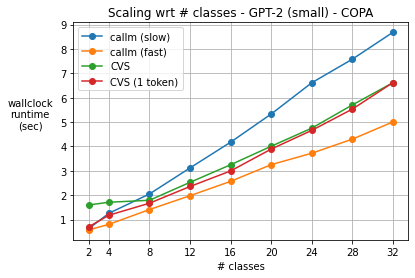

In [58]:
ax = times_df.plot(marker='o',
                   title='Scaling wrt # classes - GPT-2 (small) - COPA',
                   grid=True)
ax.set_ylabel('wallclock\nruntime\n(sec)', rotation='horizontal', labelpad=30)
ax.set_xticks(NUM_COMPLETIONS);

In [59]:
from google.colab import files
fig = ax.get_figure()
fig.patch.set_facecolor('white')
filename = 'scaling_classes.png'
fig.savefig(filename, bbox_inches="tight") ## don't cutoff ylabel
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
max_new_tokens

4

In [60]:
num_replications

5

Caption: [COPA](https://people.ict.usc.edu/~gordon/copa.html) dataset, repeating the choices to simulate multi-class classification task. [GPT-2 (small)](https://huggingface.co/gpt2) was run on a Tesla K80 GPU (whatever was free in Google Colab in March 2023, idk what info to specify here lol). Inputs were processed in batches of size 32. Each point in the graph is a mean of 5 runs. For classification via sampling (CVS), exactly 4 tokens were generated for each prompt, which is the number of tokens in `'\n\nAnswer A'`. The 1-token times are also shown, but for COPA (and other multiple-choice style prompts), that may result in significantly lower zero-shot accuracy&mdash;see the sampled completions in [this notebook](https://github.com/kddubey/callm/blob/main/demos/copa.ipynb) in section CVS.